In [1]:
# importing required packages 
import string
import pandas as pd
import json
import twitterClient
import numpy as np
import re
import nltk
import pyLDAvis.sklearn
import math
import codecs
import matplotlib.pyplot as plt
from collections import Counter
from pandas.io.json import json_normalize
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


from collections import Counter
from wordcloud import WordCloud
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\santo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# All the variables are declared and used furthur
jsonFile = 'twitter_tweets.json'
tweetThres = 50
hashtagsCounter = Counter()
client = twitterClient.twitterClient()
stemmer = PorterStemmer()
tweet = []
number_favourites = []
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []
dates=[]

In [3]:
#Json File is Loaded and the using Normilation funtion is spilt into the columnwise and saved into the Dataframe.
df = pd.DataFrame()

with open(jsonFile, 'r') as fJson:
    for line in fJson:
        tweet1 = json.loads(line)
        temp = json_normalize(tweet1, sep='_')
        df = df.append(temp[['created_at','id','text','favorited','retweet_count','favorite_count']])
        #hashtags are counted and saved in the Counter
        entities = tweet1.get('entities', {})
        hashtags = entities.get('hashtags', [])
        hashtag = [tag['text'].lower() for tag in hashtags]
        
        hashtagsCounter.update(hashtag)
        

In [4]:
#Displaying the head of the Dataframe
df.head() 

,created_at,id,text,favorited,retweet_count,favorite_count
0,Sat Aug 24 13:00:01 +0000 2019,1165247388329500672,Our vision for the perfect Weekly Update is he...,False,26,606
0,Fri Aug 23 13:00:01 +0000 2019,1164884999889272832,Did you take the leap into smoothness with the...,False,83,1469
0,Fri Aug 23 07:09:16 +0000 2019,1164796731344605185,"“I really miss overnight charging,” said no On...",False,648,6810
0,Thu Aug 22 13:00:01 +0000 2019,1164522612564926464,With great power comes great responsibility. N...,False,201,3459
0,Thu Aug 22 02:32:47 +0000 2019,1164364765692456960,@Aurabindasonu With the #OnePlus7Pro anyone ca...,False,0,2


### Preprocessing and Data Cleaning

In [5]:
#Convert the text to lower cases
df['tidy_tweet'] = df['text'].map(lambda x: x.lower())

In [6]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [7]:
#Removing the user mentions in the tweet
df['tidy_tweet'] = np.vectorize(remove_patter`n)(df['tidy_tweet'], "@[\w]*")

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-7-dffb7980a671>:2: DeprecationWarning: invalid escape sequence \w
  df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "@[\w]*")


In [8]:
#Removing the Hashtags in the tweet
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "#[\w]*")

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-8-06f941277599>:2: DeprecationWarning: invalid escape sequence \w
  df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "#[\w]*")


In [9]:
#Removing the Https in the tweets
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "(\w+:\/\/\S+)")

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-9-b3d074bf9a1e>:2: DeprecationWarning: invalid escape sequence \w
  df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tidy_tweet'], "(\w+:\/\/\S+)")


In [10]:
df

,created_at,id,text,favorited,retweet_count,favorite_count,tidy_tweet
0,Sat Aug 24 13:00:01 +0000 2019,1165247388329500672,Our vision for the perfect Weekly Update is he...,False,26,606,our vision for the perfect weekly update is he...
0,Fri Aug 23 13:00:01 +0000 2019,1164884999889272832,Did you take the leap into smoothness with the...,False,83,1469,did you take the leap into smoothness with the...
0,Fri Aug 23 07:09:16 +0000 2019,1164796731344605185,"“I really miss overnight charging,” said no On...",False,648,6810,"“i really miss overnight charging,” said no on..."
0,Thu Aug 22 13:00:01 +0000 2019,1164522612564926464,With great power comes great responsibility. N...,False,201,3459,with great power comes great responsibility. n...
0,Thu Aug 22 02:32:47 +0000 2019,1164364765692456960,@Aurabindasonu With the #OnePlus7Pro anyone ca...,False,0,2,with the anyone can take amazing portrait sh...
0,Thu Aug 22 02:23:27 +0000 2019,1164362416236331008,@TheReal_YRJ 1557 was in 1557...,False,0,13,1557 was in 1557...
0,Thu Aug 22 02:23:02 +0000 2019,1164362311701712896,"@tony_budhraj Actually no, but also yes.",False,0,7,"actually no, but also yes."
0,Wed Aug 21 13:00:01 +0000 2019,1164160225634635776,"In 1577, a beautiful portrait required weeks o...",False,68,1151,"in 1577, a beautiful portrait required weeks o..."
0,Wed Aug 21 08:19:45 +0000 2019,1164089694440710144,"Too busy for ring, but too popular for silent?...",False,76,1713,"too busy for ring, but too popular for silent?..."
0,Wed Aug 21 02:10:06 +0000 2019,1163996667839840256,RT @PeteLau: Focused on raising the benchmark ...,False,43,0,rt : focused on raising the benchmark of user ...


In [11]:
#Removing the Stopwords from the tweets
lStopwords = stopwords.words('english') + ['rt', 'via', '...', '…', '"', "'", '`']
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (lStopwords)]))

In [12]:
#Removing the Punctuations and special Chars
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [13]:
#Tokenization is done and saved into dataframe
tokenized_tweet = df['tidy_tweet'].apply(lambda x: x.split())

df['tidy_tweet'] = tokenized_tweet.to_frame()

df['strTweets'] = df['tidy_tweet'].apply(lambda x: ' '.join(map(str, x)))

In [14]:
#head of the dataframe is displayed
df.head()

,created_at,id,text,favorited,retweet_count,favorite_count,tidy_tweet,strTweets
0,Sat Aug 24 13:00:01 +0000 2019,1165247388329500672,Our vision for the perfect Weekly Update is he...,False,26,606,"[vision, perfect, weekly, update, here]",vision perfect weekly update here
0,Fri Aug 23 13:00:01 +0000 2019,1164884999889272832,Did you take the leap into smoothness with the...,False,83,1469,"[take, leap, smoothness, share, experiences, h...",take leap smoothness share experiences hz flui...
0,Fri Aug 23 07:09:16 +0000 2019,1164796731344605185,"“I really miss overnight charging,” said no On...",False,648,6810,"[i, really, miss, overnight, charging, said, o...",i really miss overnight charging said oneplus ...
0,Thu Aug 22 13:00:01 +0000 2019,1164522612564926464,With great power comes great responsibility. N...,False,201,3459,"[great, power, comes, great, responsibility, n...",great power comes great responsibility name fr...
0,Thu Aug 22 02:32:47 +0000 2019,1164364765692456960,@Aurabindasonu With the #OnePlus7Pro anyone ca...,False,0,2,"[anyone, take, amazing, portrait, shots]",anyone take amazing portrait shots


### Hashtag Visualization

In [15]:
# Counter is used to get the hashtags and stored into dataframe
df_hash = pd.DataFrame.from_dict(hashtagsCounter, orient='index').reset_index()
df_hash = df_hash.rename(columns={'index':'Hashtags', 0:'count'})
df_hash=df_hash.sort_values(by=['count'], ascending=False)

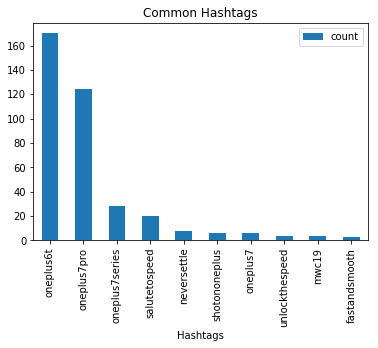

In [16]:
# Trends of the Hashtags are displayed
df_hash.head(10).plot(title='Common Hashtags',x='Hashtags', y='count', align='center', kind='bar')

plt.show()

In [17]:
# Freq count of each hash tags are displayed
for tag, count in hashtagsCounter.most_common(tweetThres):
    print(tag + ": " + str(count))

oneplus6t: 170
oneplus7pro: 124
oneplus7series: 28
salutetospeed: 20
neversettle: 8
shotononeplus: 6
oneplus7: 6
mwc19: 4
unlockthespeed: 4
onepluspopup: 3
nophoneday: 3
fastandsmooth: 3
unlockyourspeed: 3
oneplusgoexplore: 2
warpcar: 2
pmchallenge: 2
oneplus: 2
oneplustv: 1
thingsthatgivemeanxiety: 1
warpcharge30: 1
bottlecapchallenge: 1
throwbackthursday: 1
oneplus7pro5g: 1
tbt: 1
hdr10: 1
getsandstoned: 1
gameofthrones: 1
iedmilano: 1
race1000: 1
piday: 1
internationalwomensday: 1
mwc2019: 1
oneplus9: 1
stringtheory: 1
fearlesslyforward: 1
valentinesday: 1
bellletstalk: 1
legendsinaction: 1
lialive: 1
weirdtimestosaythanks: 1
happychristmas: 1
5g: 1
thunderpurple: 1
oneplusnightscape: 1


### Sentimental Analysis using Vader

In [18]:
#Iteration is done to fetch each tweet and then appending into new dataframe
analyzer = SentimentIntensityAnalyzer()
for i in range(0, len(df)):
    tweet.append(df['strTweets'].iloc[i])
    dates.append(df['created_at'].iloc[i])
    number_favourites.append(df['favorite_count'].iloc[i])
    vs_compound.append(analyzer.polarity_scores(df['strTweets'].iloc[i])['compound'])
    vs_pos.append(analyzer.polarity_scores(df['strTweets'].iloc[i])['pos'])
    vs_neu.append(analyzer.polarity_scores(df['strTweets'].iloc[i])['neu'])
    vs_neg.append(analyzer.polarity_scores(df['strTweets'].iloc[i])['neg'])

In [19]:
from pandas import Series, DataFrame

twitter_df = DataFrame({'Tweet': tweet,
                        'Date' : dates,
                        'Favourites': number_favourites,
                        'Compound': vs_compound,
                        'Positive': vs_pos,
                        'Neutral': vs_neu,
                        'Negative': vs_neg})
twitter_df = twitter_df[['Tweet','Date', 'Favourites', 'Compound',
                         'Positive', 'Neutral', 'Negative']]

# Have a look at the top 5 results.
twitter_df.head()

,Tweet,Date,Favourites,Compound,Positive,Neutral,Negative
0,vision perfect weekly update here,Sat Aug 24 13:00:01 +0000 2019,606,0.6908,0.655,0.345,0.000
1,take leap smoothness share experiences hz flui...,Fri Aug 23 13:00:01 +0000 2019,1469,0.2960,0.196,0.804,0.000
2,i really miss overnight charging said oneplus ...,Fri Aug 23 07:09:16 +0000 2019,6810,-0.2247,0.000,0.787,0.213
3,great power comes great responsibility name fr...,Thu Aug 22 13:00:01 +0000 2019,3459,0.9360,0.781,0.219,0.000
4,anyone take amazing portrait shots,Thu Aug 22 02:32:47 +0000 2019,2,0.5859,0.487,0.513,0.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C384CAAA20>]],
      dtype=object)

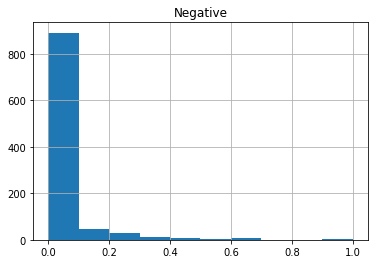

In [20]:
#Negative Sentiment plotted
twitter_df.hist(column='Negative', bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C382832080>]],
      dtype=object)

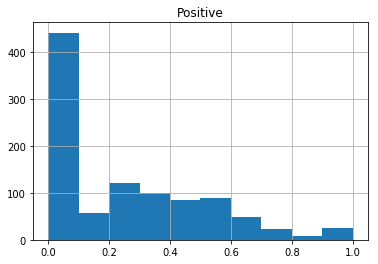

In [21]:
#Positive Sentiment plotted
twitter_df.hist(column='Positive', bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C389C2F8D0>]],
      dtype=object)

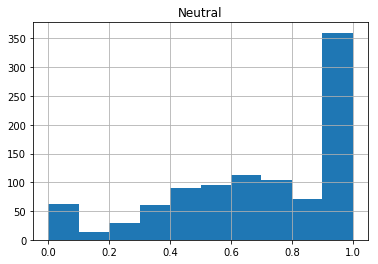

In [22]:
#Neutral Sentiment plotted
twitter_df.hist(column='Neutral', bins=10)

In [23]:
#Describes the sentiment of the Tweets
twitter_df.describe()

,Favourites,Compound,Positive,Neutral,Negative
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,1219.550000,0.270292,0.24234,0.694752,0.030907
std,1983.234982,0.336402,0.26598,0.300661,0.107466
min,0.000000,-0.585900,0.00000,0.000000,0.000000
25%,37.750000,0.000000,0.00000,0.493000,0.000000
50%,811.500000,0.216000,0.20000,0.740500,0.000000
75%,1511.500000,0.585900,0.42425,1.000000,0.000000
max,23747.000000,0.954500,1.00000,1.000000,1.000000


### Time Series with Sentimental Analysis

In [24]:
#Creating a New Dataframe for Timeseries of sentiment
analysis = DataFrame({'Date': twitter_df['Date'],
                        'sentiment' : twitter_df['Compound']})

In [25]:
analysis['Date'] = pd.to_datetime(analysis['Date'])

In [26]:
analysis.set_index('Date', inplace=True)

In [27]:
analysis[['sentiment']] = analysis[['sentiment']].apply(pd.to_numeric)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


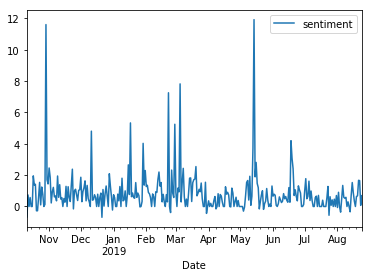

In [28]:
#Time Series Plot is plotted across the months
newSeries = analysis.resample('1D', how='sum')
newSeries.plot()
plt.show()

### Topic Modelling

In [29]:
# maximum number of words to display per topic (default = 10)
topicNum = 10
# this is the number of features/words to used to describe our documents
wordNumToDisplay = 15
featureNum = 1500

In [30]:
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum)
tf = tfVectorizer.fit_transform(df['strTweets'])
tfFeatureNames = tfVectorizer.get_feature_names()

# LDA Model
ldaModel = LatentDirichletAllocation(n_components = topicNum, max_iter=10, learning_method='batch',random_state=1000).fit(tf)

In [31]:
#Display the topics for LDA Model
def display_topics(model, featureNames, numTopWords):

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [32]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
edition mclaren weekly update camera today get find new we faster latest speed re charging
Topic 1:
we re best life us ever oneplus can new wait find speed get want join
Topic 2:
go launch event see new speed awesome tomorrow hours beyond up apps live you pop
Topic 3:
never settle that unlock screen great power smooth years battery get display fingerprint us here
Topic 4:
got favorite we oneplus know what ve right ring us great experience since camera check
Topic 5:
smooth phone really may us blue day nebula love oneplus way you thank power tell
Topic 6:
oneplus phone get community android like software better next good new experience year it best
Topic 7:
charge get gt oneplus warp fast lt ready time me favorite coming top charging them
Topic 8:
review display mirror like make day take technology smartphone try gray world phones find oneplus
Topic 9:
oneplus wireless bullets look take experience win performance sound that listen deliver launch mclaren next


In [33]:
def displayWordcloud(model, featureNames):

    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    
    #Fig size of the Wordcloud
    plt.figure(figsize=(20,10))
    
    topicNum = len(model.components_)
    plotColNum = 3
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='white')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

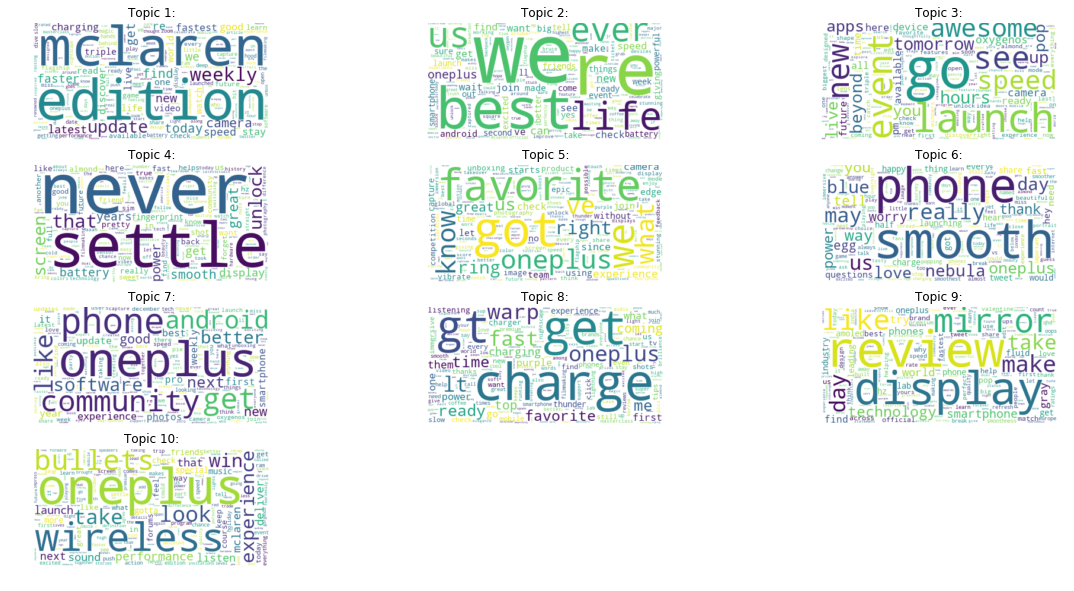

In [34]:
displayWordcloud(ldaModel, tfFeatureNames)